# Ha-Oiii temperature from 70 micron slits

The results I had before from the interpolated PV diagram was spurious. So I am going back to the individual spectra. 

In [866]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import constants
import astropy.units as u
from matplotlib import pyplot as plt
import seaborn as sns

In [867]:
datadir = Path.cwd().parent / "data/originals"
_files = sorted(datadir.glob("crN1004*.fits"))
[_.stem for _ in _files]

['crN10042_b', 'crN10043_bx', 'crN10045_bx-oiii', 'crN10047o']

## Extract 1d Ha line profile

### Read files and set up wavelength and velocity scale

In [868]:
hdu = fits.open(_files[1])[0]

In [869]:
w = WCS(hdu.header)
ny, nx = hdu.data.shape
_, waves = w.pixel_to_world_values([0]*ny, np.arange(ny))
offsets, _ = w.pixel_to_world_values(np.arange(nx), [0]*nx)

In [870]:
light_speed_kms = constants.c.to_value(u.km / u.s)
wave0 = 6562.78
vels = light_speed_kms * (waves - wave0) / wave0

### Remove the ISM line

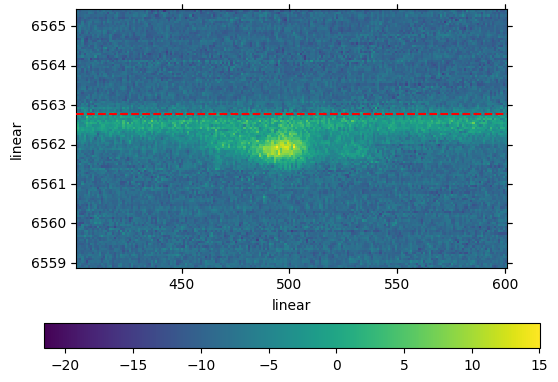

In [871]:
# wav_window = slice(330, 390)
# pos_window = slice(440, 560)
# convert to default float since fits image was big endian
im = hdu.data.astype("float")
# bg = p(pixels)[wav_window, None]
# im -= bg
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
_ = ax.imshow(im, interpolation="none")
ax.set_xlim(400, 600)
ax.set_ylim(300, 420)
x0, y0 = w.world_to_pixel_values(0, wave0)
ax.axhline(y0, color="r", ls="dashed")
fig.colorbar(_, ax=ax, orientation="horizontal")

In [872]:
bg = np.median(im, axis=1, keepdims=True)

This is the extraction window for the spectrum, which is calculated below from the spatial profile of oiii, and is then checked against ha in the section "Compare O and H slit profiles"

But I make it slightly wider by a couple of pixels

We want to maximize the s/n, given as (H, O):
* +20: (25.6459120165339, 20.052371884681953)
* +10: (27.391007652546566, 24.699174894569474)
* +5: (29.635714758067774, 27.340601860786055)
* +0: (28.580506824191794, 24.987232676535623)
* -3: (34.545704284991594, 30.702939329642422)
* -5: (39.3694668539912, 31.944563476900655)
* -7: (39.976260944514706, 31.756643992224294)
* -10: (32.52877296954868, 25.570777917781328)
* -12: (28.51519044445098, 19.70224957177104)

So it does look like -5 is best, which is just 17 pixels at peak

In [873]:
# i1, i2 = 487, 507
extra = -5
i1, i2 = 483 - extra, 510 + extra


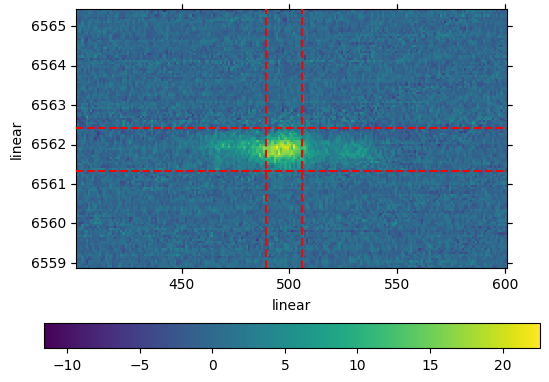

In [874]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
_ = ax.imshow(im - bg, interpolation="none")
ax.set_xlim(400, 600)
ax.set_ylim(300, 420)
x0, y0 = w.world_to_pixel_values(0, wave0)
ax.axhline(345, color="r", ls="dashed")
ax.axhline(365, color="r", ls="dashed")
ax.axvline(i1, color="r", ls="dashed")
ax.axvline(i2, color="r", ls="dashed")
fig.colorbar(_, ax=ax, orientation="horizontal")

In [875]:
noise_var = 1.6 + 0.17 * im
imm = im - bg

### Spatial profile

In [876]:
yslice = slice(345, 365)
# yslice = slice(350, 360)
profile = np.sum(imm[yslice, :], axis=0)
sprofile = np.sqrt(np.sum(noise_var[yslice, :], axis=0))

/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_92803/186753298.py:4: RuntimeWarning: invalid value encountered in sqrt
  sprofile = np.sqrt(np.sum(noise_var[yslice, :], axis=0))


In [877]:
is_bright = profile >= 0.5 * np.max(profile)
ii1 = np.min(offsets[is_bright]).astype(int)
ii2 = np.max(offsets[is_bright]).astype(int)
ii1, ii2

(483, 507)

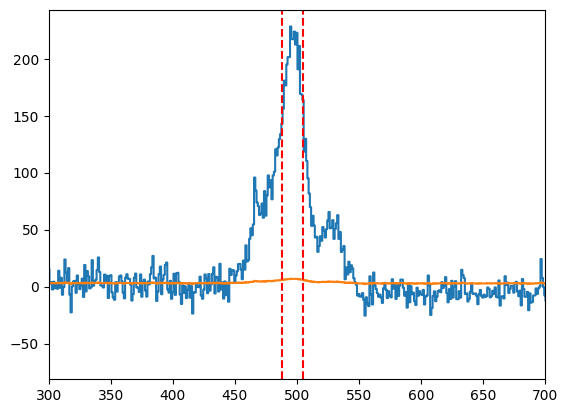

In [878]:
fig, ax = plt.subplots()
ds = "steps-mid"             
ax.plot(offsets, profile, ds=ds)
ax.plot(offsets, sprofile, ds=ds)
# ax.fill_between(offsets, profile + sprofile, profile - sprofile)
ax.set_xlim(300, 700)
ax.axvline(i1, color="r", ls="dashed")
ax.axvline(i2, color="r", ls="dashed")

In [879]:
np.std(profile[300:450]), np.mean(profile[300:450])

(9.326378734745425, 2.7024016467109324)

In [880]:
np.nanmean(sprofile[300:450])

3.08519937157776

In [881]:
np.nanstd(imm[yslice, 300:450]), np.nanmean(imm[yslice, 300:450])

(1.602172638731623, 0.13512008233554662)

Save these so we can reuse the variable names

In [882]:
offsets_h = offsets
slitprofile_h = profile

### Line profile

/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_92803/551844711.py:6: RuntimeWarning: invalid value encountered in sqrt
  sprofile = np.sqrt(np.sum(noise_var[:, xslice], axis=1))


(6555.0, 6570.0)

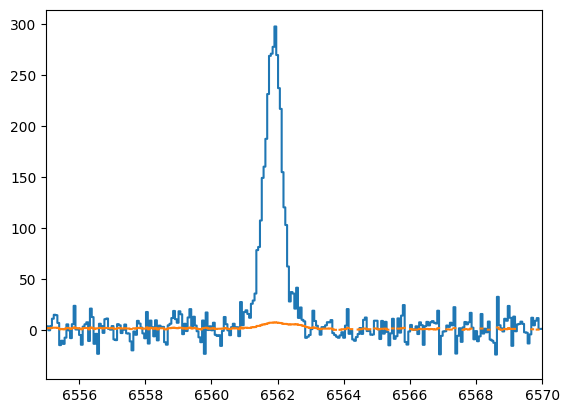

In [883]:
fig, ax = plt.subplots()
yslice = slice(345, 365)
xslice = slice(i1, i2)
# yslice = slice(350, 360)
profile = np.sum(imm[:, xslice], axis=1)
sprofile = np.sqrt(np.sum(noise_var[:, xslice], axis=1))
ds = "steps-mid"             
ax.plot(waves, profile, ds=ds)
ax.plot(waves, sprofile, ds=ds)
ax.set_xlim(6555, 6570)

(-150.0, 150.0)

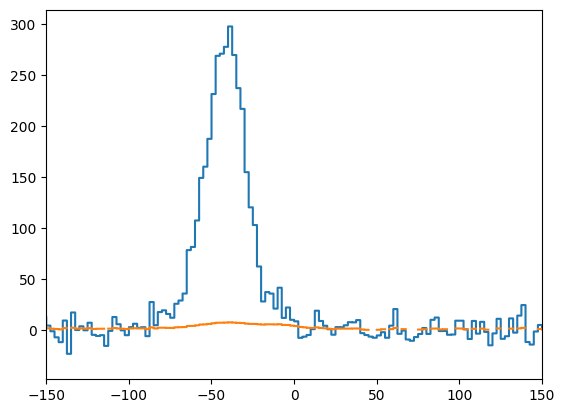

In [884]:
fig, ax = plt.subplots()
ax.plot(vels, profile, ds=ds)
ax.plot(vels, sprofile, ds=ds)
ax.set_xlim(-150, 150)

In [885]:
window = (vels > -100) & (vels < 0)
vmean_ha = np.average(vels[window], weights=profile[window])
vmean_ha

-41.9808216205618

In [886]:
idata, vdata = {}, {}

In [887]:
idata["ha"] = profile / np.sum(profile[window])
vdata["ha"] = vels - vmean_ha

## Extract 1d Oiii profile

### Read files and set up wavelength and velocity scale

In [888]:
hdu = fits.open(_files[2])[0]

In [889]:
w = WCS(hdu.header)
ny, nx = hdu.data.shape
_, waves = w.pixel_to_world_values([0]*ny, np.arange(ny))
offsets, _ = w.pixel_to_world_values(np.arange(nx), [0]*nx)

In [890]:
light_speed_kms = constants.c.to_value(u.km / u.s)
wave0 = 5006.8
vels = light_speed_kms * (waves - wave0) / wave0

### Remove the ISM line

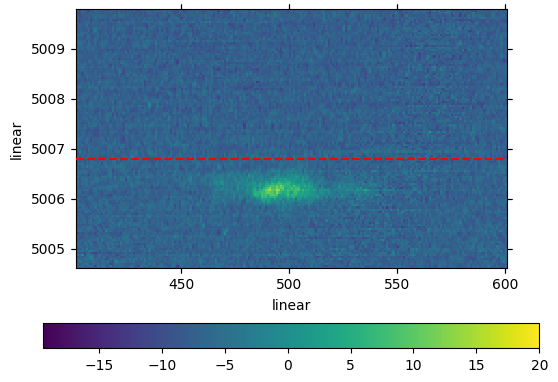

In [891]:
# convert to default float since fits image was big endian
im = hdu.data.astype("float")
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
_ = ax.imshow(im, interpolation="none", vmax=20)
ax.set_xlim(400, 600)
ax.set_ylim(300, 420)
x0, y0 = w.world_to_pixel_values(0, wave0)
ax.axhline(y0, color="r", ls="dashed")
fig.colorbar(_, ax=ax, orientation="horizontal")

In [892]:
bg = np.median(im, axis=1, keepdims=True)

This comes from the spatial profile section below. It is the half-intensity points. But I do not set it here, so there is only one place to set it

In [893]:

# i1, i2 = 483, 510

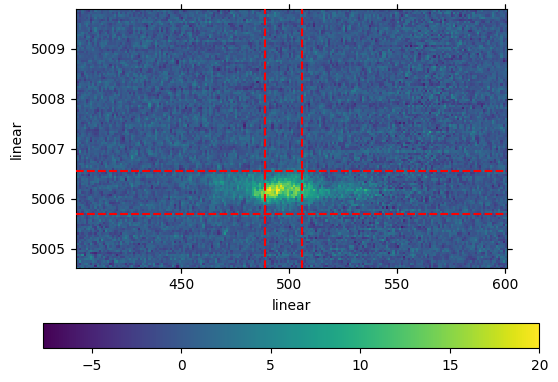

In [894]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
_ = ax.imshow(im - bg, interpolation="none", vmax=20)
ax.set_xlim(400, 600)
ax.set_ylim(300, 420)
x0, y0 = w.world_to_pixel_values(0, wave0)
ax.axhline(325, color="r", ls="dashed")
ax.axhline(345, color="r", ls="dashed")
ax.axvline(i1, color="r", ls="dashed")
ax.axvline(i2, color="r", ls="dashed")
fig.colorbar(_, ax=ax, orientation="horizontal")

In [895]:
noise_var = 1.6 + 0.17 * im
imm = im - bg

### Spatial profile

In [896]:
yslice = slice(325, 345)
# yslice = slice(350, 360)
profile = np.sum(imm[yslice, :], axis=0)
sprofile = np.sqrt(np.sum(noise_var[yslice, :], axis=0))


In [897]:
is_bright = profile >= 0.5 * np.max(profile)
ii1 = np.min(offsets[is_bright]).astype(int)
ii2 = np.max(offsets[is_bright]).astype(int)
ii1, ii2

(483, 510)

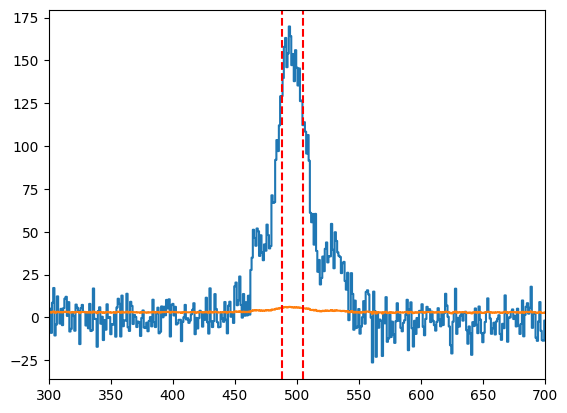

In [898]:
fig, ax = plt.subplots()

ds = "steps-mid"             
ax.plot(offsets, profile, ds=ds)
ax.plot(offsets, sprofile, ds=ds)
# ax.fill_between(offsets, profile + sprofile, profile - sprofile)
ax.set_xlim(300, 700)
ax.axvline(i1, color="r", ls="dashed")
ax.axvline(i2, color="r", ls="dashed")

In [899]:
np.std(profile[300:450]), np.mean(profile[300:450])

(7.128583680442333, 0.3124381017684936)

In [900]:
np.nanmean(sprofile[300:450])

3.009991714265315

In [901]:
np.nanstd(imm[yslice, 300:450]), np.nanmean(imm[yslice, 300:450])

(1.463515299408126, 0.015621905088424683)

In [902]:
offsets_o = offsets
slitprofile_o = profile

### Compare O and H slit profiles

I want to get a better handle on the best spatial window to use for extracting the spectrum, and to check that the slit profiles of the two lines are similar enough.

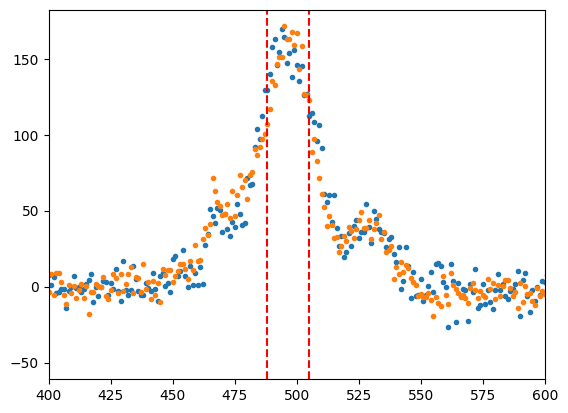

In [903]:
fig, ax = plt.subplots()

ds = "steps-mid"             
ax.plot(offsets_o, slitprofile_o, ".")
ax.plot(offsets_h, 0.75 * slitprofile_h, ".")

ax.set_xlim(400, 600)
ax.axvline(i1, color="r", ls="dashed")
ax.axvline(i2, color="r", ls="dashed")

So after multiplying Ha by 0.75, we get a fery close agreement between the two. This is strong evidence that the slit positions coincide. 

We are showing ii1, ii2, which were calculated as the half power points of the oiii profile. These look like good choices for integrating the line profiles. So, i will canonize them as i1 and i2, which I will insert above.

In [904]:
ii1, ii2

(483, 510)

### Line profile

/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_92803/1846245743.py:7: RuntimeWarning: invalid value encountered in sqrt
  sprofile = np.sqrt(np.sum(noise_var[:, xslice], axis=1))


(5000.0, 5015.0)

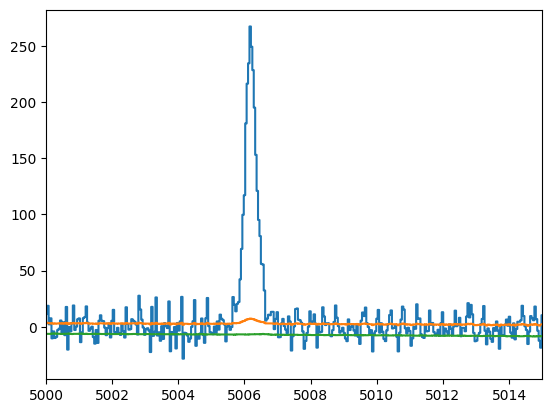

In [905]:
fig, ax = plt.subplots()
yslice = slice(325, 345)
xslice = slice(i1, i2)
# yslice = slice(350, 360)
profile = np.sum(imm[:, xslice], axis=1)
profile0 = np.sum(im[:, xslice], axis=1)
sprofile = np.sqrt(np.sum(noise_var[:, xslice], axis=1))
ds = "steps-mid"             
ax.plot(waves, profile, ds=ds)
ax.plot(waves, sprofile, ds=ds)
ax.plot(waves, bg, ds=ds)
ax.set_xlim(5000, 5015)

(-150.0, 150.0)

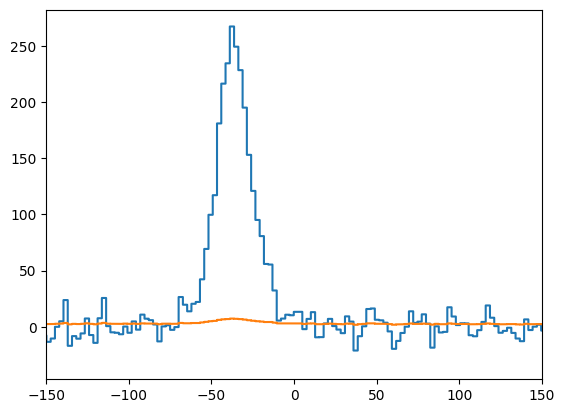

In [906]:
fig, ax = plt.subplots()
ax.plot(vels, profile, ds=ds)
ax.plot(vels, sprofile, ds=ds)
ax.set_xlim(-150, 150)

In [907]:
window = (vels > -100) & (vels < 0)
vmean_oiii = np.average(vels[window], weights=profile[window])
vmean_oiii

-36.40688544606328

In [908]:
idata["oiii"] = profile / np.sum(profile[window])
vdata["oiii"] = vels - vmean_oiii

## Compare two lines

(-70.0, 70.0)

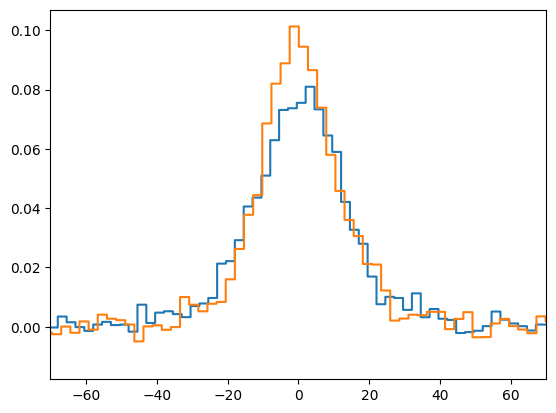

In [909]:
fig, ax = plt.subplots()
ax.plot(vdata["ha"], idata["ha"], ds=ds)
ax.plot(vdata["oiii"], idata["oiii"], ds=ds)
ax.set_xlim(-70, 70)

Turns out that the pixels are not quite the same size in velocity

In [910]:
np.diff(vdata["oiii"])[0], np.diff(vdata["ha"])[0]

(2.579591702433163, 2.498936314386242)

In [911]:
np.diff(vdata["oiii"])[0] / np.diff(vdata["ha"])[0]

1.0322758877777687

### Fit single Gaussians to get a better estimate of the central velocity of each line

In [912]:
from astropy.modeling import models, fitting

In [913]:
fitter = fitting.LevMarLSQFitter()
gfits = {}
for lineid in vdata.keys():
    gfits[lineid] = fitter(
        models.Gaussian1D(amplitude=0.1, mean=0.0, stddev=10.0), 
        vdata[lineid], idata[lineid],
    )


In [914]:
gfits

{'ha': <Gaussian1D(amplitude=0.07705297, mean=0.58396992, stddev=12.39996516)>,
 'oiii': <Gaussian1D(amplitude=0.0942154, mean=-0.05931046, stddev=10.55211342)>}

Set definitive velocity arrays for the two lines, centered on the mean velocity of the gaussian fit.

In [915]:
vel_h = vdata["ha"] - gfits["ha"].mean
vel_o = vdata["oiii"] - gfits["oiii"].mean

and short aliases for the intensity profiles, observed and fitted. This is because I am going to start smoothing and interpolating from one to another, so the long descriptors will get unwieldy

In [916]:
i_h = idata["ha"]
i_o = idata["oiii"]
g_h = gfits["ha"](vdata["ha"])
g_o = gfits["oiii"](vdata["oiii"])


Check that I have not messed up with the velocity shifts. The gaussian discrete profiles should be centered on zero, when evaluated on the shifted velocity arrays

In [917]:
np.average(vel_h, weights=g_h), np.average(vel_o, weights=g_o)

(4.633675790721511e-16, 4.561037796607896e-16)

Those are reassuringly small

### CANCELLED - Final refinement to velocity zero points

But we also want to see how the mean velocities of the observed lines compare in a restricted window. 

In [918]:
is_bright_h = g_h > 0.01
dv_h = np.average(vel_h[is_bright_h], weights=i_h[is_bright_h])
is_bright_o = g_o > 0.01
dv_o = np.average(vel_o[is_bright_o], weights=i_o[is_bright_o])
dv_h, dv_o

(-0.5764040764052273, 0.45548568228697317)

That is what I suspected, that there is a slight difference. This is due to a tension between the wings and the peak. *However, it is very sensitive to the threshold brightness that I choose*

I will experiment with an alternative centering that uses these mean values. 

In [919]:
vel_hh = vdata["ha"] - gfits["ha"].mean - dv_h
vel_oo = vdata["oiii"] - gfits["oiii"].mean - dv_o

Sanity check to make sure I have applied shifts in the right direction:

In [920]:
check_h = np.average(vel_hh[is_bright_h], weights=i_h[is_bright_h])
check_o = np.average(vel_oo[is_bright_o], weights=i_o[is_bright_o])
check_h, check_o

(7.030067816003581e-16, 2.3591206702020843e-16)

I am not totally convinced that this is the best thing to do, since it will make the discrepancy at the peak larger, but it should help with the wings. **No, it makes everything worse, so I am not using it**

### Refine normalization of the line

We previously did this over the entire spectrum, which is probably inaccurate since it is bringing in a load of irrelevant fluctuations.

So check the normalization over the core of the line. We can try it two ways – from the data or from the gaussian fits. For the data, we use `trapz` to integrate, which takes into account the different bin widths

In [921]:
is_core_h = (np.abs(vel_h) < 40)
is_core_o = (np.abs(vel_o) < 40)
factor = (
    np.trapz(i_h[is_core_h], vel_h[is_core_h]) 
    / np.trapz(i_o[is_core_o], vel_o[is_core_o])
)
factor2 = (
    gfits["ha"].stddev * gfits["ha"].amplitude 
    / (gfits["oiii"].stddev * gfits["oiii"].amplitude)
)
factor, factor2

(0.95195498109702, 0.9610555543504495)

These are very similar to one another. So, we will adjust the brightness of the Ha profile to give the same normalization as Oiii

In [922]:
i_h = idata["ha"] / factor
g_h = gfits["ha"](vdata["ha"]) / factor


### Plot the profiles and fits

(-80.0, 80.0)

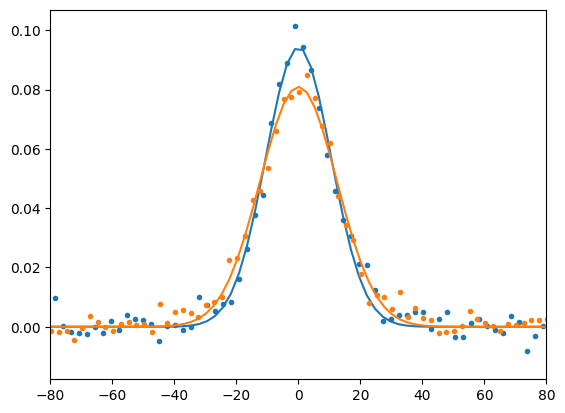

In [923]:
fig, ax = plt.subplots()


# line, = ax.plot(vel_o, i_o, ds="steps-mid")
line, = ax.plot(vel_o, i_o, ".")
ax.plot(vel_o, g_o, color=line.get_color())

# line, = ax.plot(vel_h, i_h, ds="steps-mid")
line, = ax.plot(vel_h, i_h, ".")
ax.plot(vel_h, g_h, color=line.get_color())

ax.set_xlim(-80, 80)

RMS widths of the gaussian fits

In [924]:
sig_h = gfits["ha"].stddev
sig_o = gfits["oiii"].stddev
sig_extra = np.sqrt(sig_h ** 2 - sig_o ** 2)
sig_h.value, sig_o.value, sig_extra

(12.399965163530208, 10.552113423263854, 6.512452561004764)

Simple measurement of temperature

In [925]:
T4 = (sig_extra**2 - 10.2) / 77.34
T4

0.41649907369197714

So that is pretty cold! 3500 K, but we have no error bars. We will get those from the convolution

### Check the noise levels

In [926]:
from utils_chatgpt import sliding_std

In [927]:
sliding_std(np.arange(6))

array([nan,  1.,  1.,  1.,  1., nan])

Calculate sigma of residuals between observations and gaussian fit with a n-point sliding window

In [928]:
nwin = 5
s_h = sliding_std(i_h - g_h, nwin)
s_o = sliding_std(i_o - g_o, nwin)


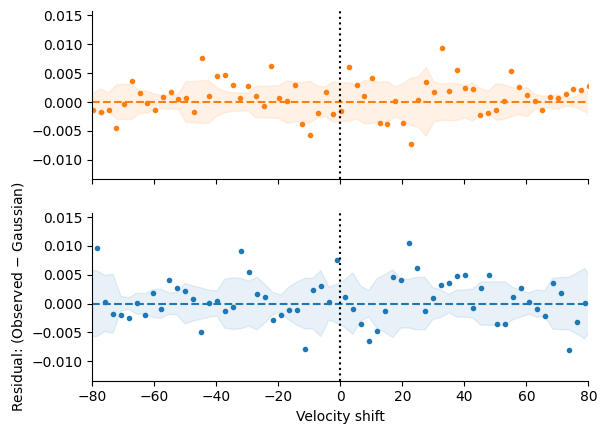

In [929]:
fig, (axh, axo) = plt.subplots(2, 1, sharex=True, sharey=True)

line, = axo.plot(vel_o, i_o - g_o, ".")
c = line.get_color()
axo.fill_between(vel_o, s_o, -s_o, color=c, alpha=0.1)
axo.axhline(0, color=c, linestyle="dashed")

c = "C1"
line, = axh.plot(vel_h, i_h - g_h, ".", color=c)
axh.fill_between(vel_h, s_h, -s_h, color=c, alpha=0.1)
axh.axhline(0, color=c, linestyle="dashed")

for ax in axh, axo:
    ax.axvline(0, color="k", linestyle="dotted", zorder=100)
axo.set_xlim(-80, 80)
axo.set_xlabel("Velocity shift")
axo.set_ylabel("Residual: (Observed $-$ Gaussian)")
sns.despine()

The residuals do not increase significantly in the line core, which means they must be dominated by noise and that the noise is roughly constant

In [930]:
is_outer_h = (np.abs(vel_h) < 80) & (~is_core_h)
is_outer_o = (np.abs(vel_o) < 80) & (~is_core_o)
print(f"Outer pixels: {np.sum(is_outer_h)}, {np.sum(is_outer_o)}")
print(f"Core pixels: {np.sum(is_core_h)}, {np.sum(is_core_o)}")


Outer pixels: 32, 31
Core pixels: 32, 31


In [931]:
s_h_core = np.mean(s_h[is_core_h])
s_o_core = np.mean(s_o[is_core_o])
s_h_outer = np.mean(s_h[is_outer_h])
s_o_outer = np.mean(s_o[is_outer_o])
print(f"Outer rms residulas: {s_h_outer:.4f}, {s_o_outer:.4f}")
print(f"Core rms residuals: {s_h_core:.4f}, {s_o_core:.4f}")


Outer rms residulas: 0.0022, 0.0032
Core rms residuals: 0.0031, 0.0037


So they are slightly higher in the core of the line, which may be due to non-gaussian profile. So I will use the outer value to define the noise sigma

In [932]:
s_noise = np.sqrt(s_h_outer**2 + s_o_outer**2)
s_noise

0.0038370748217109963

And we can calculate the S/N ratios

In [933]:
snr_h = np.max(i_h) / s_h_outer
snr_o = np.max(i_o) / s_o_outer
snr_h, snr_o

(39.3694668539912, 31.944563476900655)

## Interpolate Ha onto Oiii velocities and vice versa

Since Ha is slightly broader, it should be less affected by the interpolation

In [934]:
i_ho = np.interp(vel_o, vel_h, i_h)
i_oh = np.interp(vel_h, vel_o, i_o)

g_ho = np.interp(vel_o, vel_h, g_h)

(-80.0, 80.0)

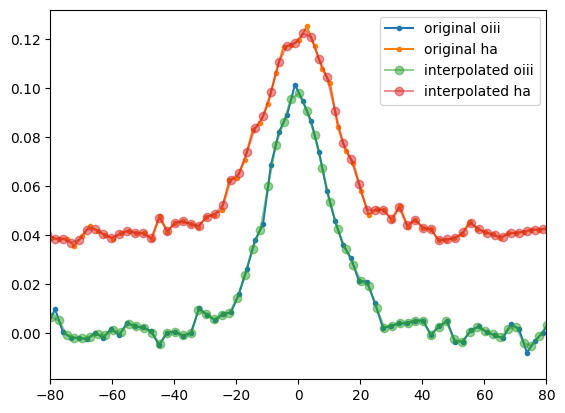

In [935]:
fig, ax = plt.subplots()
offset = 0.04


# line, = ax.plot(vel_o, i_o, ds="steps-mid")
line, = ax.plot(vel_o, i_o, ".-", label="original oiii")
line, = ax.plot(vel_h, offset + i_h, ".-", label="original ha")

line, = ax.plot(vel_h, i_oh, "o-", label="interpolated oiii", alpha=0.5)
line, = ax.plot(vel_o, offset + i_ho, "o-", label="interpolated ha", alpha=0.5)
ax.legend()
ax.set_xlim(-80, 80)

So the interpolation does smoothe off the peaks slightly, but they are probably due to noise anyway ...

### Residuals between raw profiles

Now look at the residuals with the interpolation in both directions

In [936]:
fwhm_h = sig_h * np.sqrt(8 * np.log(2))
fwhm_o = sig_o * np.sqrt(8 * np.log(2))
fwhm_h, fwhm_o

(29.199686524766406, 24.848328206541876)

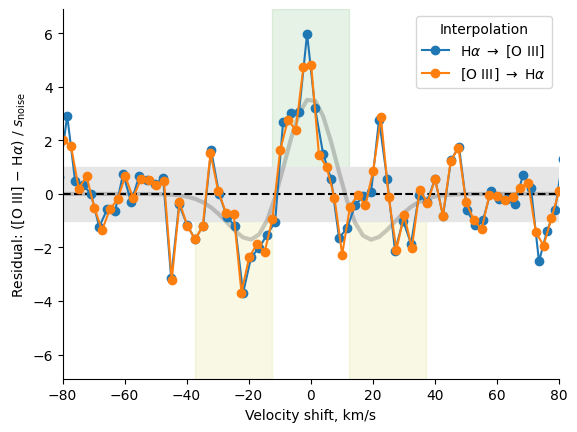

In [937]:
fig, ax = plt.subplots()
ax.plot(vel_o, (i_o - i_ho) / s_noise, "o-", label=r"H$\alpha$ $\to$ [O III]")
ax.plot(vel_h, (i_oh - i_h) / s_noise, "o-", label=r"[O III] $\to$ H$\alpha$")

ax.plot(vel_o, (g_o - g_ho) / s_noise, "-", color="k", alpha=0.2, lw=3
        , zorder=-100)

ax.axhline(0, color="k", linestyle="dashed", zorder=-100)
ax.axhspan(-1, 1, color="0.9", zorder=-200)
ax.axvspan(
    -1.5 * fwhm_o, -0.5 * fwhm_o, 
    ymin=0, ymax=0.5,
    color="y", alpha=0.1, zorder=-300,
)
ax.axvspan(
    0.5 * fwhm_o, 1.5 * fwhm_o, 
    ymin=0, ymax=0.5,
    color="y", alpha=0.1, zorder=-300,
)
ax.axvspan(
    -fwhm_o / 2, fwhm_o / 2, 
    ymin=0.5, ymax=1.0,
    color="g", alpha=0.1, zorder=-300,
)
ax.legend(title="Interpolation")
ax.set_ylim(-6.9, 6.9)
ax.set_xlim(-80, 80)
ax.set_xlabel("Velocity shift, km/s")
ax.set_ylabel(r"Residual: ([O III] $-$ H$\alpha$) / $s_\mathrm{noise}$")
sns.despine()

This shows predominantly positive residual in the core (green shading) and predominantly negative residuals in the wings (yellow shading), although this latter is a lot noisier and more evident on the blue than the red side. 

*Perhaps, the subtraction of the ISM line is unduly affecting the red side. Although I do not believe this to be the case, since it looks loke the issue is a real skewness in the oiii profile, which is not so prominent in H alpha. This causes the positive residuals around +20 km/s* 

I also show the residual between the two gaussian fits as the gray line, which more clearly shows the expected sombrero profile. 

Note that there is no significant difference between the two interpolations. The biggest difference is near the peak of the lines, and even there it is minor. 